In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.mstats import winsorize

# Path to your CSV (change if needed)
DATA_PATH ="C:\\Users\\Sukesh\\Downloads\\archive\\student_exam_scores.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please place the CSV at that path or change DATA_PATH.")

In [2]:
# 1) Load dataset
df = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", df.shape)
print("\n--- Head ---")
print(df.head())
print("\n--- Tail ---")
print(df.tail())

Loaded dataset shape: (200, 6)

--- Head ---
  student_id  hours_studied  sleep_hours  attendance_percent  previous_scores  \
0       S001            8.0          8.8                72.1               45   
1       S002            1.3          8.6                60.7               55   
2       S003            4.0          8.2                73.7               86   
3       S004            3.5          4.8                95.1               66   
4       S005            9.1          6.4                89.8               71   

   exam_score  
0        30.2  
1        25.0  
2        35.8  
3        34.0  
4        40.3  

--- Tail ---
    student_id  hours_studied  sleep_hours  attendance_percent  \
195       S196           10.5          5.4                94.0   
196       S197            7.1          6.1                85.1   
197       S198            1.6          6.9                63.8   
198       S199           12.0          7.3                50.5   
199       S200           10.

In [3]:
# 2) Data types and summary
print("\n--- Data types ---")
print(df.dtypes)
print("\n--- Non-null counts ---")
print(df.count())
print("\n--- Numeric summary (.describe()) ---")
print(df.describe())
print("\n--- Full summary (.describe(include='all')) ---")
print(df.describe(include='all'))


--- Data types ---
student_id             object
hours_studied         float64
sleep_hours           float64
attendance_percent    float64
previous_scores         int64
exam_score            float64
dtype: object

--- Non-null counts ---
student_id            200
hours_studied         200
sleep_hours           200
attendance_percent    200
previous_scores       200
exam_score            200
dtype: int64

--- Numeric summary (.describe()) ---
       hours_studied  sleep_hours  attendance_percent  previous_scores  \
count     200.000000   200.000000          200.000000       200.000000   
mean        6.325500     6.622000           74.830000        66.800000   
std         3.227317     1.497138           14.249905        15.663869   
min         1.000000     4.000000           50.300000        40.000000   
25%         3.500000     5.300000           62.200000        54.000000   
50%         6.150000     6.700000           75.250000        67.500000   
75%         9.000000     8.025000  

In [4]:
# 3) Data Cleaning
print("\n--- Missing values per column ---")
missing = df.isnull().sum()
print(missing)
missing_prop = missing / len(df)
print("\nMissing proportions:\n", missing_prop)

df_clean = df.copy()

# Drop columns with >40% missing
cols_to_drop = missing_prop[missing_prop > 0.4].index.tolist()
if cols_to_drop:
    print("Dropping columns with >40% missing:", cols_to_drop)
    df_clean.drop(columns=cols_to_drop, inplace=True)

# Split numeric & categorical
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

# Impute numeric with median, categorical with mode (or 'Missing' if no mode)
for col in numeric_cols:
    if df_clean[col].isnull().any():
        med = df_clean[col].median()
        df_clean[col].fillna(med, inplace=True)
        print(f"Imputed numeric '{col}' with median = {med}")

for col in cat_cols:
    if df_clean[col].isnull().any():
        mode_vals = df_clean[col].mode()
        if len(mode_vals) > 0:
            mode_val = mode_vals[0]
            df_clean[col].fillna(mode_val, inplace=True)
            print(f"Filled categorical '{col}' with mode = {mode_val}")
        else:
            df_clean[col].fillna('Missing', inplace=True)
            print(f"Filled categorical '{col}' with 'Missing'")

print("\nMissing after imputation:")
print(df_clean.isnull().sum())

# Remove duplicate rows
dups_count = df_clean.duplicated().sum()
print(f"\nDuplicate rows found: {dups_count}")
if dups_count > 0:
    df_clean.drop_duplicates(inplace=True)
    print(f"Dropped {dups_count} duplicates.")
print("Shape after cleaning:", df_clean.shape)


--- Missing values per column ---
student_id            0
hours_studied         0
sleep_hours           0
attendance_percent    0
previous_scores       0
exam_score            0
dtype: int64

Missing proportions:
 student_id            0.0
hours_studied         0.0
sleep_hours           0.0
attendance_percent    0.0
previous_scores       0.0
exam_score            0.0
dtype: float64

Missing after imputation:
student_id            0
hours_studied         0
sleep_hours           0
attendance_percent    0
previous_scores       0
exam_score            0
dtype: int64

Duplicate rows found: 0
Shape after cleaning: (200, 6)


In [5]:
# 4) Outlier detection (IQR) and winsorization
outlier_summary = {}
for col in numeric_cols:
    if col not in df_clean.columns:
        continue
    s = df_clean[col].dropna().astype(float)
    if s.empty:
        continue
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    out_count = s[(s < lower) | (s > upper)].shape[0]
    outlier_summary[col] = {'count': out_count, 'lower': lower, 'upper': upper, 'IQR': IQR}
    print(f"{col}: {out_count} outliers (lower < {lower:.3f}, upper > {upper:.3f})")

# Create a winsorized copy (1% each tail) for robust plots/stats
df_wins = df_clean.copy()
for col in numeric_cols:
    if col not in df_wins.columns:
        continue
    if outlier_summary.get(col, {}).get('count', 0) > 0:
        try:
            arr = df_wins[col].astype(float).values
            df_wins[col] = winsorize(arr, limits=[0.01, 0.01])
            print(f"Winsorized '{col}' (1% each tail).")
        except Exception as e:
            print("Winsorize error for", col, e)



hours_studied: 0 outliers (lower < -4.750, upper > 17.250)
sleep_hours: 0 outliers (lower < 1.212, upper > 12.113)
attendance_percent: 0 outliers (lower < 24.362, upper > 125.263)
previous_scores: 0 outliers (lower < 15.000, upper > 119.000)
exam_score: 0 outliers (lower < 15.625, upper > 52.625)


In [6]:
# 5) Univariate analysis (numeric)
print("\n--- Univariate (numeric) ---")
for col in numeric_cols:
    if col not in df_clean.columns:
        continue
    s = df_clean[col].dropna().astype(float)
    mean = s.mean()
    median = s.median()
    trimmed_mean = stats.trim_mean(s, 0.1)
    rng = s.max() - s.min()
    var = s.var(ddof=1)
    std = s.std(ddof=1)
    print(f"{col}: mean={mean:.3f}, median={median:.3f}, trimmed_mean_10%={trimmed_mean:.3f}, range={rng:.3f}, var={var:.3f}, std={std:.3f}")

# Univariate (categorical)
print("\n--- Univariate (categorical) ---")
for col in cat_cols:
    if col not in df_clean.columns:
        continue
    print(f"\n{col} value counts:")
    print(df_clean[col].value_counts().head(10))
    print("Modes:", df_clean[col].mode().tolist())


--- Univariate (numeric) ---
hours_studied: mean=6.325, median=6.150, trimmed_mean_10%=6.278, range=11.000, var=10.416, std=3.227
sleep_hours: mean=6.622, median=6.700, trimmed_mean_10%=6.638, range=5.000, var=2.241, std=1.497
attendance_percent: mean=74.830, median=75.250, trimmed_mean_10%=74.939, range=49.700, var=203.060, std=14.250
previous_scores: mean=66.800, median=67.500, trimmed_mean_10%=66.694, range=55.000, var=245.357, std=15.664
exam_score: mean=33.955, median=34.050, trimmed_mean_10%=33.936, range=34.200, var=46.098, std=6.790

--- Univariate (categorical) ---

student_id value counts:
student_id
S001    1
S002    1
S003    1
S004    1
S005    1
S006    1
S007    1
S008    1
S009    1
S010    1
Name: count, dtype: int64
Modes: ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031',

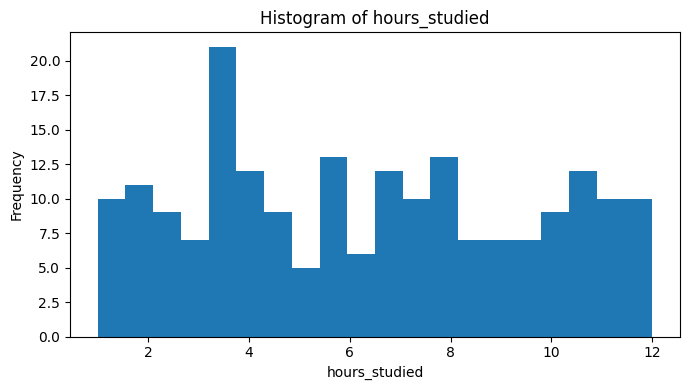

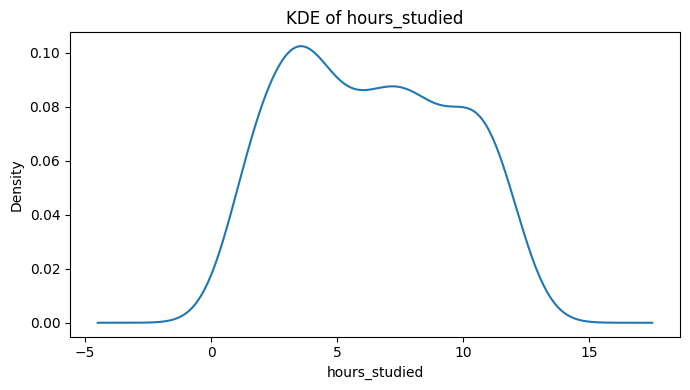

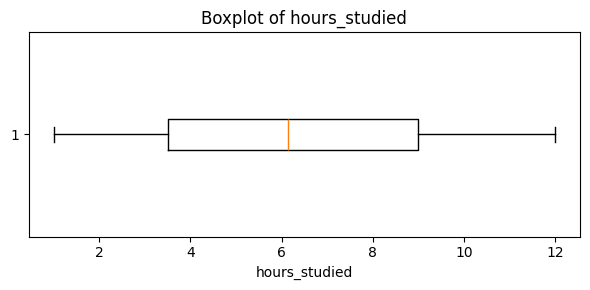

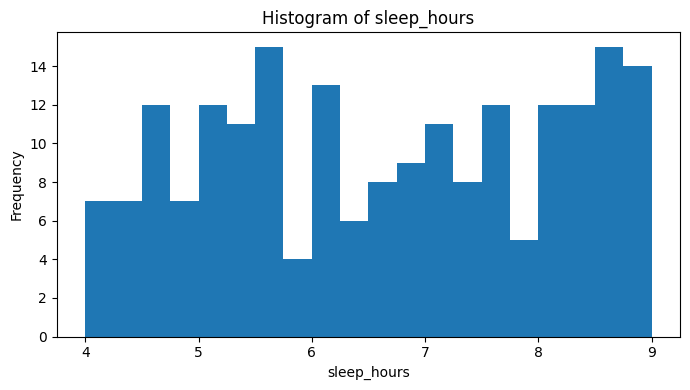

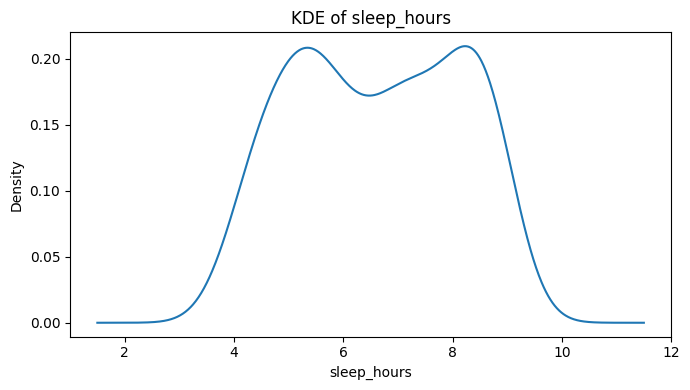

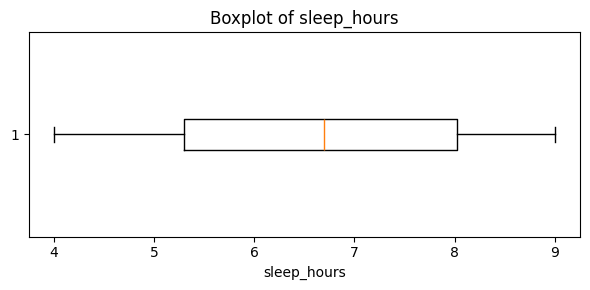

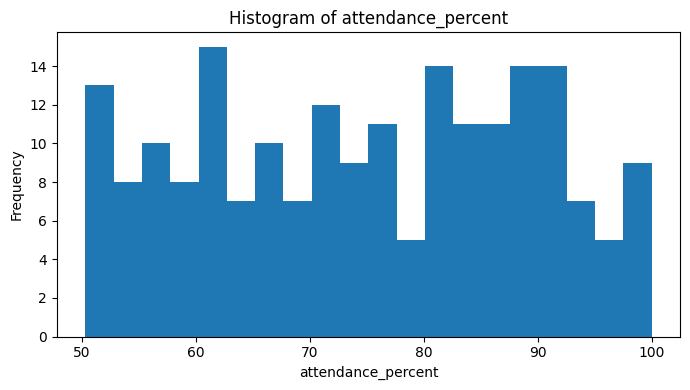

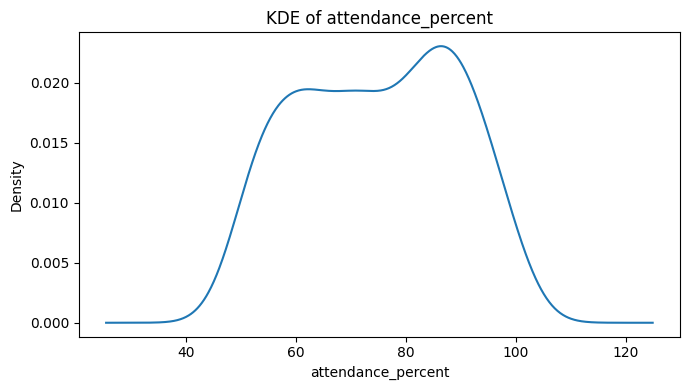

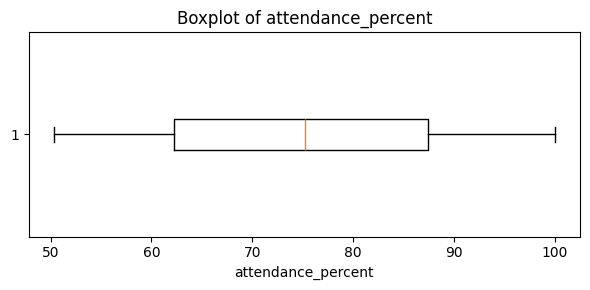

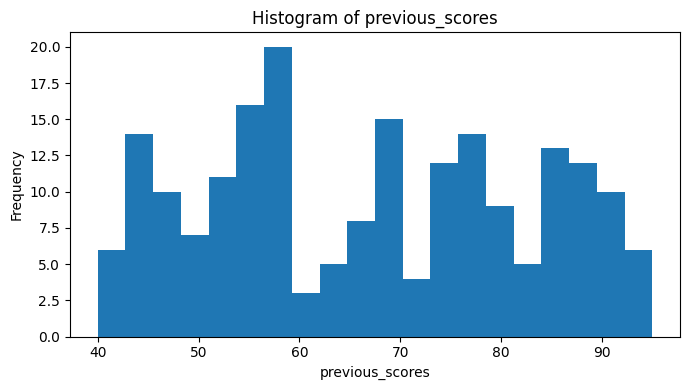

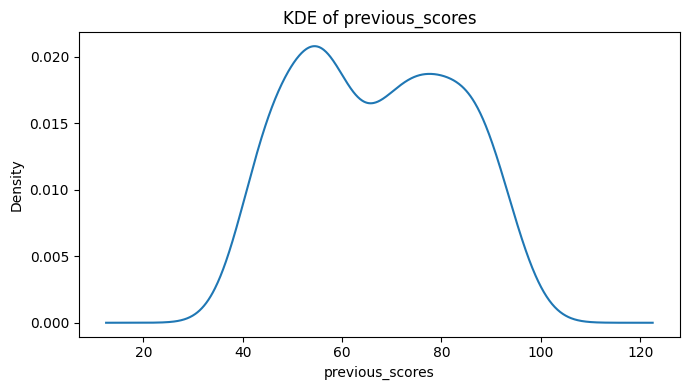

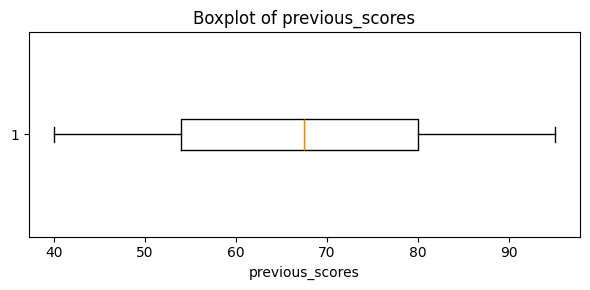

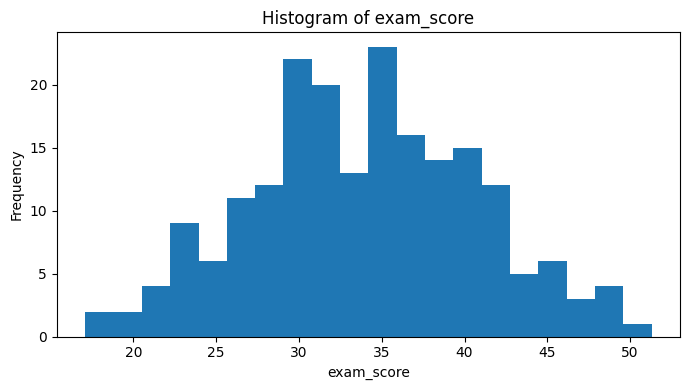

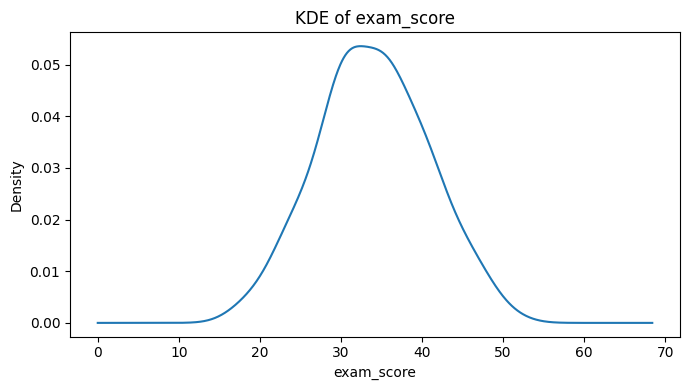

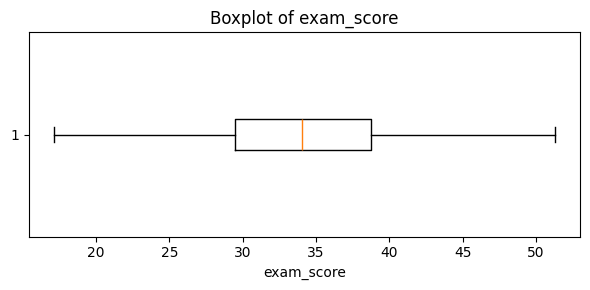

In [7]:
# 6) Visualizations: histograms, KDEs, boxplots (one fig per plot)
for col in numeric_cols:
    if col not in df_clean.columns:
        continue
    s = df_clean[col].dropna().astype(float)
    if s.empty:
        continue
    # Histogram
    plt.figure(figsize=(7,4))
    plt.hist(s, bins=20)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # KDE
    plt.figure(figsize=(7,4))
    try:
        s.plot.kde()
        plt.title(f"KDE of {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("KDE error for", col, e)

    # Boxplot
    plt.figure(figsize=(6,3))
    plt.boxplot(s, vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


Numeric columns: ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores', 'exam_score']


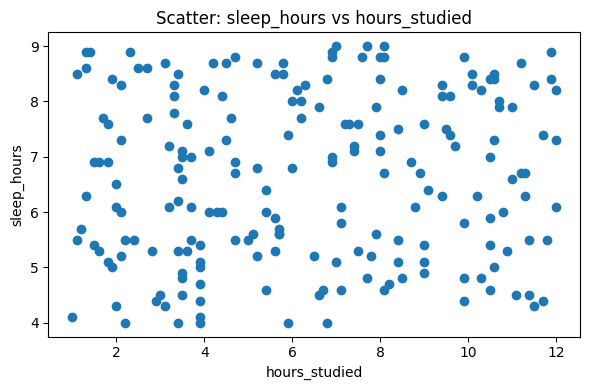

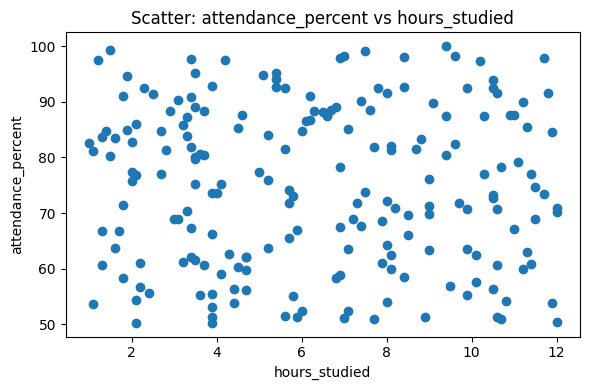

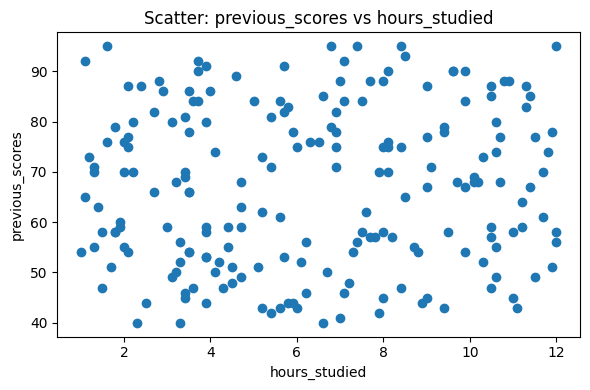

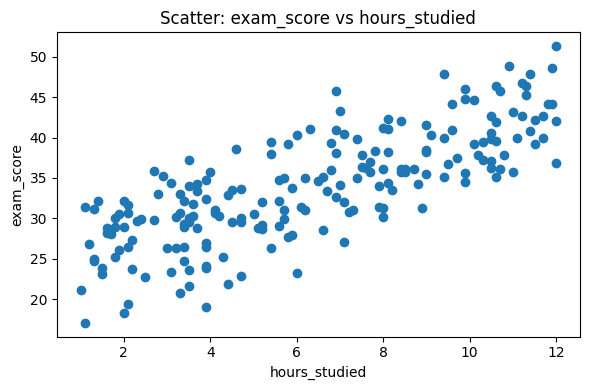

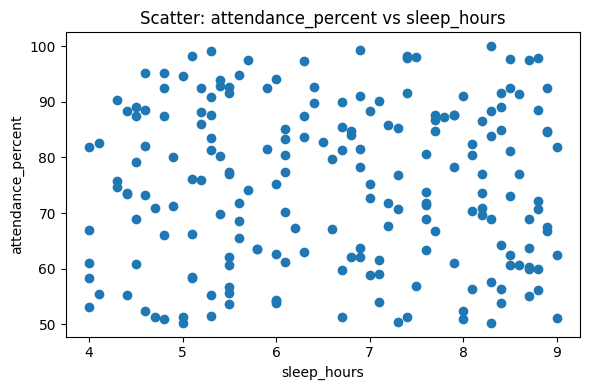

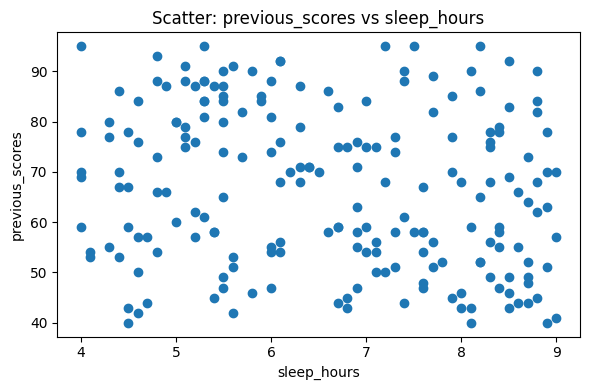


Correlation matrix:
                    hours_studied  sleep_hours  attendance_percent  \
hours_studied            1.000000     0.077864           -0.031311   
sleep_hours              0.077864     1.000000            0.000572   
attendance_percent      -0.031311     0.000572            1.000000   
previous_scores          0.069078    -0.194251            0.051958   
exam_score               0.776751     0.188222            0.225713   

                    previous_scores  exam_score  
hours_studied              0.069078    0.776751  
sleep_hours               -0.194251    0.188222  
attendance_percent         0.051958    0.225713  
previous_scores            1.000000    0.431105  
exam_score                 0.431105    1.000000  


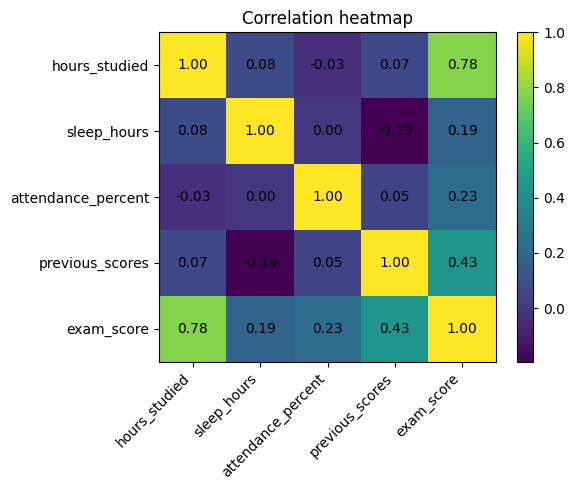

<Figure size 1000x500 with 0 Axes>

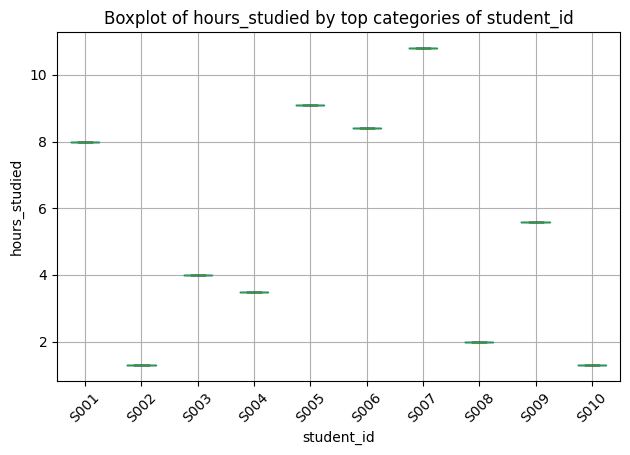

In [8]:
# 7) Bivariate/Multivariate
numeric_present = [c for c in numeric_cols if c in df_clean.columns]
print("\nNumeric columns:", numeric_present)

# Scatter plots (limit to first 6 pairs)
pairs = []
for i in range(len(numeric_present)):
    for j in range(i+1, len(numeric_present)):
        pairs.append((numeric_present[i], numeric_present[j]))

for (xcol, ycol) in pairs[:6]:
    plt.figure(figsize=(6,4))
    plt.scatter(df_clean[xcol], df_clean[ycol])
    plt.title(f"Scatter: {ycol} vs {xcol}")
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.tight_layout()
    plt.show()

# Correlation matrix + heatmap (matplotlib + annotations)
if len(numeric_present) >= 2:
    corr = df_clean[numeric_present].corr()
    print("\nCorrelation matrix:")
    print(corr)
    plt.figure(figsize=(6,5))
    im = plt.imshow(corr, aspect='auto', interpolation='nearest')
    plt.colorbar(im)
    plt.xticks(range(len(numeric_present)), numeric_present, rotation=45, ha='right')
    plt.yticks(range(len(numeric_present)), numeric_present)
    # annotate
    for i in range(len(numeric_present)):
        for j in range(len(numeric_present)):
            plt.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center')
    plt.title("Correlation heatmap")
    plt.tight_layout()
    plt.show()

# Grouped boxplots (categorical vs numeric)
if cat_cols and numeric_present:
    cat = cat_cols[0]
    num = numeric_present[0]
    top_cats = df_clean[cat].value_counts().nlargest(10).index.tolist()
    subset = df_clean[df_clean[cat].isin(top_cats)]
    plt.figure(figsize=(10,5))
    subset.boxplot(column=num, by=cat, rot=45)
    plt.title(f"Boxplot of {num} by top categories of {cat}")
    plt.suptitle("")
    plt.xlabel(cat)
    plt.ylabel(num)
    plt.tight_layout()
    plt.show()